In [5]:
import numpy as np
import matplotlib.pyplot as plt
import ultranest
import read_beam_FEKO as rf
from ultranest.plot import cornerplot
import scipy.interpolate

In [6]:
o = rf.read_beam_FEKO('nominal.out',0)

 Frequency in Hz:               FREQ =    2.50000E+07

 Frequency in Hz:               FREQ =    2.60000E+07

 Frequency in Hz:               FREQ =    2.70000E+07

 Frequency in Hz:               FREQ =    2.80000E+07

 Frequency in Hz:               FREQ =    2.90000E+07

 Frequency in Hz:               FREQ =    3.00000E+07

 Frequency in Hz:               FREQ =    3.10000E+07

 Frequency in Hz:               FREQ =    3.20000E+07

 Frequency in Hz:               FREQ =    3.30000E+07

 Frequency in Hz:               FREQ =    3.40000E+07

 Frequency in Hz:               FREQ =    3.50000E+07

 Frequency in Hz:               FREQ =    3.60000E+07

 Frequency in Hz:               FREQ =    3.70000E+07

 Frequency in Hz:               FREQ =    3.80000E+07

 Frequency in Hz:               FREQ =    3.90000E+07

 Frequency in Hz:               FREQ =    4.00000E+07

 Frequency in Hz:               FREQ =    4.10000E+07

 Frequency in Hz:               FREQ =    4.20000E+07

 Frequency

In [7]:
theta = 90 - o[2]
phi = o[1]
freq = o[0]
gain = o[5]
theta, phi = np.meshgrid(theta, phi)

In [8]:
theta

array([[90., 89., 88., ...,  2.,  1.,  0.],
       [90., 89., 88., ...,  2.,  1.,  0.],
       [90., 89., 88., ...,  2.,  1.,  0.],
       ...,
       [90., 89., 88., ...,  2.,  1.,  0.],
       [90., 89., 88., ...,  2.,  1.,  0.],
       [90., 89., 88., ...,  2.,  1.,  0.]])

In [9]:
phi

array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  1.,   1.,   1., ...,   1.,   1.,   1.],
       [  2.,   2.,   2., ...,   2.,   2.,   2.],
       ...,
       [357., 357., 357., ..., 357., 357., 357.],
       [358., 358., 358., ..., 358., 358., 358.],
       [359., 359., 359., ..., 359., 359., 359.]])

In [10]:
sigma = 0.6613*180/np.pi
#make sigma a input parameter
def Acos(R, theta, miu, nu):
    part1 = np.cos(miu*theta*np.pi/180)*(R/(sigma/1.43))**miu
    part2 = P(miu,nu,R**2/(sigma/1.43)**2)
    part3 = np.exp(-R**2/(4*(sigma/1.43)**2))
    return part1*part2*part3

def Asin(R, theta, miu, nu):
    part1 = np.sin(miu*theta*np.pi/180)*(R/(sigma/1.43))**miu
    part2 = P(miu,nu,R**2/(sigma/1.43)**2)
    part3 = np.exp(-R**2/(4*(sigma/1.43)**2))
    return part1*part2*part3

def P(miu,nu,u):
    terms = []
    p = 0
    while p <= nu:
        up = np.math.factorial(miu + nu)*np.math.factorial(nu)
        down = np.math.factorial(miu + p)*np.math.factorial(p)*np.math.factorial(nu-p)
        term = (-2)**(nu-p)* up/down * u[i][j]**p
        terms.append(term)
        p += 1
    print(terms)
    
def P(miu,nu,u):
    terms = []
    p = 0
    while p <= nu:
        up = np.math.factorial(miu + nu)*np.math.factorial(nu)
        down = np.math.factorial(miu + p)*np.math.factorial(p)*np.math.factorial(nu-p)
        term = (-2)**(nu-p)* up/down * u**p
        terms.append(term)
        p += 1
    terms = np.array(terms)
    return np.sum(terms,axis = 0)

#Normalization
def normalize(array):
    q = 0
    theta = 0
    while theta <= 90:
        for i in range(360):
            q += (array[theta*360 + i])**2 * (np.pi/180)**2 * np.sin(theta*np.pi/180)
        theta += 1
    return array/q

def TDH(rank):
    """return matrix A = [f1, f2, f3, ...] for rank 0 to rank TDH functions"""
    zz00c = Acos(xx, yy, 0, 0)
    zz00c2d = zz00c.flatten()
    array = normalize(zz00c2d)
    r = 1
    while r <= rank:
        m = 0
        while m <= r:
            if (r - m)%2 == 0:
                n = (r - m)/2
                if m == 0:
                    cosine = Acos(xx,yy,m,n)
                    cosine2d = cosine.flatten()
                    ncos = normalize(cosine2d)
                    array = np.vstack((array, ncos))
                    m += 2
                else:
                    cosine = Acos(xx,yy,m,n)
                    cosine2d = cosine.flatten()
                    ncos = normalize(cosine2d)
                    sine = Asin(xx,yy,m,n)
                    sine2d = sine.flatten()
                    nsin = normalize(sine2d)
                    array = np.vstack((array, ncos))
                    array = np.vstack((array, nsin))
                    m += 2
            else:
                m += 1
        r += 1
    matrix = np.matrix(array).T
    return matrix

def model(rank, coe):
    A = TDH(rank)
    a = np.matrix(coe).T
    return np.matmul(A,a)

def simulation(coe, sigma):
    rank = 0
    count = 1
    length = len(coe) - 1
    while length > count:
        rank += 1
        count += rank + 1
    mo = model(rank,coe)
    noise = np.random.default_rng().normal(0.0, sigma*np.max(mo),360*91)
    noi = np.matrix(noise).T
    data = mo + noi
    return data

def solve(A, data):
    AT = A.T
    ATA = np.matmul(AT,A)
    ATAinverse = np.linalg.inv(ATA)
    half = np.matmul(ATAinverse,AT)
    x = np.matmul(half,data)
    return x

def residual(A,data):
    x = solve(A, data)
    AT = A.T
    fittingmodel = np.matmul(A, x)
    r = data - fittingmodel
    return r

def residual2D(A,data):
    r = residual(A,data)
    r2D = r.reshape(360,91)
    return r2D

def covariance(A,data):
    AT = A.T
    ATA = np.matmul(AT,A)
    ATAinverse = np.linalg.inv(ATA)
    r = residual(A,data)
    rT = r.T
    rTr = np.matmul(rT,r)
    s = rTr/((len(data))-10)
    s2 = s.item(0)
    covariance = s2*ATAinverse
    return covariance

In [11]:
def Gaussian2D(A, sigx, sigy):
    return A * np.exp(-(theta*np.pi/180*np.cos(phi*np.pi/180))**2/2/sigx**2 - (theta*np.pi/180*np.sin(phi*np.pi/180))**2/2/sigy**2) 


In [12]:
# Define model to simulate data
def model1(paras):
    A, sigx, sigy = paras
    return Gaussian2D(A,sigx,sigy).T

In [13]:
sigma = np.std(gain[0])
param_names = ['A', 'sigx', 'sigy']
def my_prior_transform(cube):
    params = cube.copy()

    # transform location parameter: uniform prior
    lo = 0
    hi = 1
    params[0] = cube[0] * (hi - lo) + lo

    lo = 0
    hi = 2
    params[1] = cube[1] * (hi - lo) + lo

    lo = 0
    hi = 2
    params[1] = cube[1] * (hi - lo) + lo
    
    return params
def my_likelihood(params):
    mo = model1(params)
    diff = mo - gain[0]
    return -0.5 * np.sum((diff/sigma)**2)

In [14]:
sampler = ultranest.ReactiveNestedSampler(param_names, my_likelihood, my_prior_transform)

In [15]:
result = sampler.run(min_num_live_points=200)
sampler.print_results()

[ultranest] Sampling 200 live points from prior ...


[ultranest] Explored until L=-2e+02  .78 [-185.8393..-185.8392]*| it/evals=3920/7959 eff=50.5220% N=200   0  
[ultranest] Likelihood function evaluations: 7980
[ultranest]   logZ = -200.9 +- 0.1569
[ultranest] Effective samples strategy satisfied (ESS = 908.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.16, need <0.5)
[ultranest]   logZ error budget: single: 0.26 bs:0.16 tail:0.01 total:0.16 required:<0.50
[ultranest] done iterating.

logZ = -200.894 +- 0.333
  single instance: logZ = -200.894 +- 0.262
  bootstrapped   : logZ = -200.945 +- 0.332
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    A                   : 0.5275│ ▁ ▁▁▁▁▁▁▁▂▂▃▂▃▄▅▅▆▇▇▇▇▇▅▄▃▂▁▂▁▁▁▁▁▁▁▁ │0.5427    0.5354 +- 0.0019
    sigx                : 0.6432│ ▁ ▁ ▁▁▁▁▁▂▂▃▃▄▅▆▇▇▇▇▆▄▅▃▃▂▂▂▁▁▁▁▁  ▁▁ │0.6798    0.6611 +- 0.0042
    sigy              

In [16]:
xx = theta
yy = phi
sigx = 0.6612
sigy = 0.7030
ratio = sigy/sigx

In [17]:
yy = yy*ratio

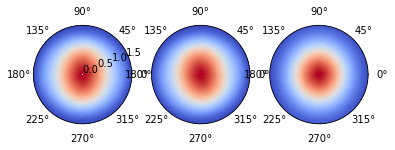

In [18]:
fig, axs = plt.subplots(1, 3, subplot_kw=dict(projection="polar"),sharex='all', sharey='all')
axs[0].pcolormesh(phi*np.pi/180,theta*np.pi/180,gain[0].T.reshape(360,91),cmap='coolwarm',shading='auto')
axs[1].pcolormesh(yy*np.pi/180,xx*np.pi/180,gain[0].T.reshape(360,91),cmap='coolwarm',shading='auto')
axs[2].pcolormesh(phi*np.pi/180,theta*np.pi/180,Gaussian2D(0.5354,0.6613,0.7026),cmap='coolwarm',shading='auto')

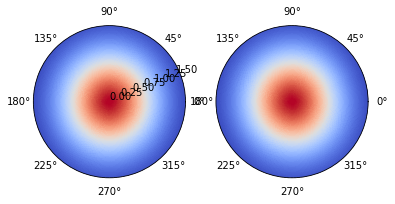

In [19]:
fig, axs = plt.subplots(1, 2, subplot_kw=dict(projection="polar"),sharex='all', sharey='all')
axs[0].pcolormesh(phi*np.pi/180,theta*np.pi/180,Gaussian2D(0.5354,0.6613,0.7026),cmap='coolwarm',shading='auto')
axs[1].pcolormesh(yy*np.pi/180,xx*np.pi/180,Gaussian2D(0.5354,0.6613,0.7026),cmap='coolwarm',shading='auto')

<ipython-input-43-560e08549ebf>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axs[0].pcolormesh(phi*np.pi/180,theta*np.pi/180,Gaussian2D(0.5354,sigx,sigy),cmap='coolwarm')
<ipython-input-43-560e08549ebf>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axs[1].pcolormesh(yy*np.pi/180,xx*np.pi/180,Gaussian2D(0.5354,sigx,sigy),cmap='coolwarm')


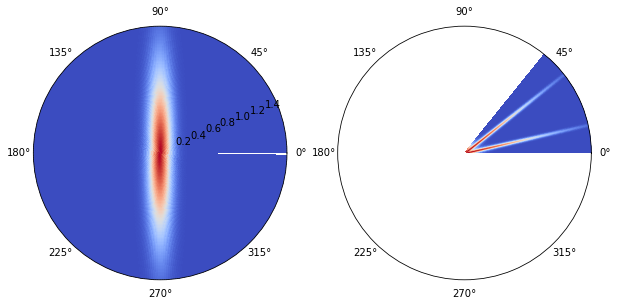

In [43]:
xx = theta
yy = phi
sigx = 0.1
sigy = 0.7030
ratio = sigx/sigy
yy = yy*ratio
fig, axs = plt.subplots(1, 2, subplot_kw=dict(projection="polar"), figsize = (10,20),sharex='all', sharey='all')
axs[0].pcolormesh(phi*np.pi/180,theta*np.pi/180,Gaussian2D(0.5354,sigx,sigy),cmap='coolwarm')
axs[1].pcolormesh(yy*np.pi/180,xx*np.pi/180,Gaussian2D(0.5354,sigx,sigy),cmap='coolwarm')

<ipython-input-44-916e9ca20550>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axs[0].pcolormesh(phi*np.pi/180,theta*np.pi/180,Gaussian2D(0.5354,sigx,sigy),cmap='coolwarm')
<ipython-input-44-916e9ca20550>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axs[1].pcolormesh(yy*np.pi/180,xx*np.pi/180,Gaussian2D(0.5354,sigx,sigy),cmap='coolwarm')


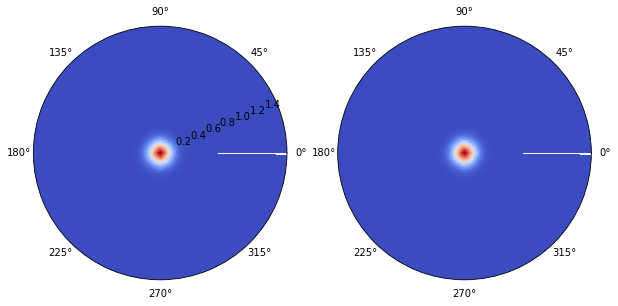

In [44]:
xx = theta
yy = phi
sigx = 0.1
#sigy = 0.7030
#ratio = sigx/sigy
#yy = yy*ratio
sigy = sigx
fig, axs = plt.subplots(1, 2, subplot_kw=dict(projection="polar"), figsize = (10,20),sharex='all', sharey='all')
axs[0].pcolormesh(phi*np.pi/180,theta*np.pi/180,Gaussian2D(0.5354,sigx,sigy),cmap='coolwarm')
axs[1].pcolormesh(yy*np.pi/180,xx*np.pi/180,Gaussian2D(0.5354,sigx,sigy),cmap='coolwarm')

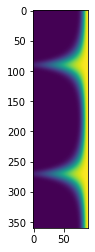

In [34]:
plt.imshow(Gaussian2D(0.5354,sigx,sigy))

In [37]:
yy.T[0]

array([   0.  ,    7.03,   14.06,   21.09,   28.12,   35.15,   42.18,
         49.21,   56.24,   63.27,   70.3 ,   77.33,   84.36,   91.39,
         98.42,  105.45,  112.48,  119.51,  126.54,  133.57,  140.6 ,
        147.63,  154.66,  161.69,  168.72,  175.75,  182.78,  189.81,
        196.84,  203.87,  210.9 ,  217.93,  224.96,  231.99,  239.02,
        246.05,  253.08,  260.11,  267.14,  274.17,  281.2 ,  288.23,
        295.26,  302.29,  309.32,  316.35,  323.38,  330.41,  337.44,
        344.47,  351.5 ,  358.53,  365.56,  372.59,  379.62,  386.65,
        393.68,  400.71,  407.74,  414.77,  421.8 ,  428.83,  435.86,
        442.89,  449.92,  456.95,  463.98,  471.01,  478.04,  485.07,
        492.1 ,  499.13,  506.16,  513.19,  520.22,  527.25,  534.28,
        541.31,  548.34,  555.37,  562.4 ,  569.43,  576.46,  583.49,
        590.52,  597.55,  604.58,  611.61,  618.64,  625.67,  632.7 ,
        639.73,  646.76,  653.79,  660.82,  667.85,  674.88,  681.91,
        688.94,  695

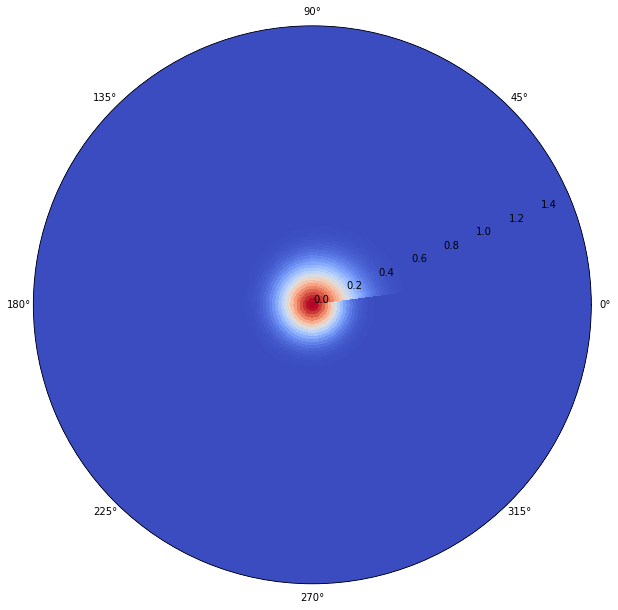

In [22]:
fig, axs = plt.subplots(1, 1, subplot_kw=dict(projection="polar"), figsize = (10,20))
axs.pcolormesh(yy*np.pi/180,xx*np.pi/180,Gaussian2D(0.5354,sigx,sigy),cmap='coolwarm',shading='auto')

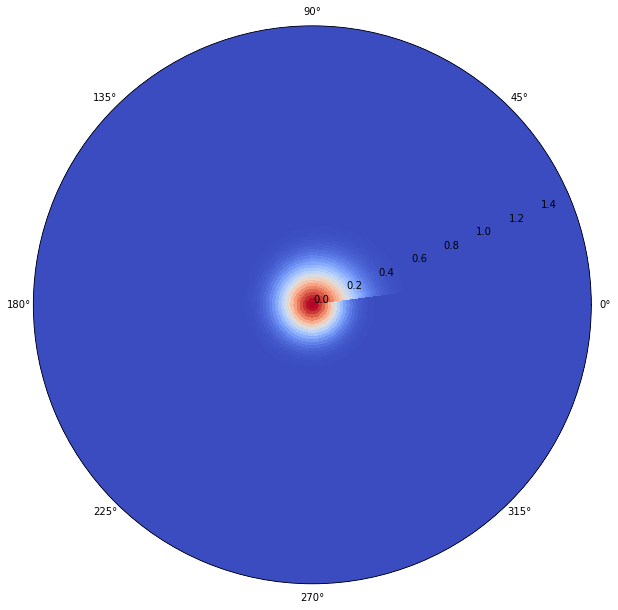

In [42]:
fig, axs = plt.subplots(1, 1, subplot_kw=dict(projection="polar"), figsize = (10,20))
axs.pcolormesh(yy*np.pi/180,xx*np.pi/180,Gaussian2D(0.5354,sigx,sigy),cmap='coolwarm',shading='auto')

In [24]:
gains = np.array([gain[0].T.flatten()])

In [25]:
TDH20 = TDH(20)

In [26]:
TDHcube = []
j = 1
for i in range(20):
    TDHcube.append(TDH20[:,:(i+j)])
    j += i+1

In [27]:
A = TDHcube[5]
coe = solve(A,gains.T)
finalresi = residual2D(A,gains.T)
fittingmodel = np.matmul(A, coe)
fittingmodel2D = fittingmodel.reshape(360,91)

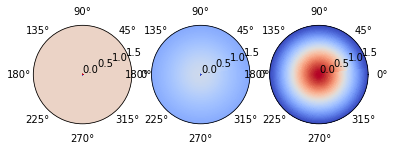

In [28]:
fig, axs = plt.subplots(1, 3, subplot_kw=dict(projection="polar"))
axs[0].pcolormesh(yy*np.pi/180,xx*np.pi/180,fittingmodel2D,cmap='coolwarm',shading='auto')
axs[1].pcolormesh(yy*np.pi/180,xx*np.pi/180,finalresi,cmap='coolwarm',shading='auto')
axs[2].pcolormesh(yy*np.pi/180,xx*np.pi/180,gain[0].T,cmap='coolwarm',shading='auto')

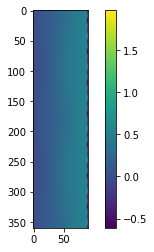

In [29]:
plt.imshow(finalresi)
plt.colorbar()

In [30]:
coetotal = []
frtotal = []
covtotal = []
fittingmodeltotal = []
for i in range(20):
    A = TDHcube[i]
    coe = solve(A,gains.T)
    finalresi = residual2D(A,gains.T)
    fittingmodel = np.matmul(A, coe)
    fittingmodel2D = fittingmodel.reshape(360,91)
    cov = covariance(A, gains.T)
    coetotal.append(coe)
    frtotal.append(finalresi)
    covtotal.append(cov)
    fittingmodeltotal.append(fittingmodel2D)

In [31]:
sigmatotal = []
for i in covtotal:
    sigmatotal.append(np.diag(i))

In [32]:
pctotal = []
for i in range(20):
    meansquare = np.sum(np.multiply(frtotal[i],frtotal[i]))/(360*91)
    rms = np.sqrt(meansquare)
    pctotal.append(rms/np.max(gain[0])*100)

In [203]:
pctotal[6]

0.42854870144663443

In [175]:
len(TDHcube[6].T)

28

In [194]:
A = (TDHcube[6].T[:22]).T
coe = solve(A,gains.T)
finalresi = residual2D(A,gains.T)
fittingmodel = np.matmul(A, coe)
fittingmodel2D = fittingmodel.reshape(360,91)

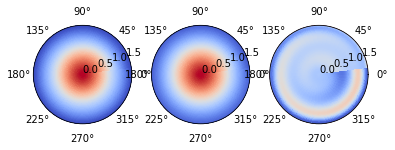

In [205]:
fig, axs = plt.subplots(1, 3, subplot_kw=dict(projection="polar"))
axs[0].pcolormesh(yy*np.pi/180,xx*np.pi/180,gain[0].T,cmap='coolwarm',shading='auto')
axs[1].pcolormesh(yy*np.pi/180,xx*np.pi/180,fittingmodel2D,cmap='coolwarm',shading='auto')
axs[2].pcolormesh(yy*np.pi/180,xx*np.pi/180,finalresi,cmap='coolwarm',shading='auto')

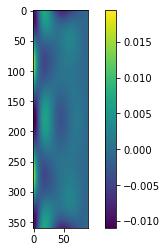

In [196]:
plt.imshow(finalresi)
plt.colorbar()

In [222]:
3.7058072950321385e-200

3.7058072950321385e-200

In [229]:
gain[0]

array([[1.00002303e-100, 1.00002303e-100, 1.00002303e-100, ...,
        1.00002303e-100, 1.00002303e-100, 1.00002303e-100],
       [9.67453277e-004, 9.67275082e-004, 9.66696175e-004, ...,
        9.65739511e-004, 9.66696175e-004, 9.67275082e-004],
       [3.51714279e-003, 3.51649497e-003, 3.51455222e-003, ...,
        3.51115499e-003, 3.51447129e-003, 3.51649497e-003],
       ...,
       [5.22877555e-001, 5.22877555e-001, 5.22877555e-001, ...,
        5.22877555e-001, 5.22877555e-001, 5.22877555e-001],
       [5.23443728e-001, 5.23443728e-001, 5.23443728e-001, ...,
        5.23443728e-001, 5.23443728e-001, 5.23443728e-001],
       [5.23636607e-001, 5.23636607e-001, 5.23636607e-001, ...,
        5.23636607e-001, 5.23636607e-001, 5.23636607e-001]])

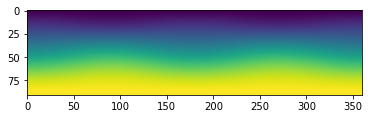

In [230]:
plt.imshow(gain[0])

In [232]:
gain[0].shape

(91, 360)

In [1]:
gain[0].T[0]

NameError: name 'gain' is not defined

In [240]:
gain[0].T[59]

array([1.00002303e-100, 4.84484626e-004, 1.83041683e-003, 3.90454111e-003,
       6.60328436e-003, 9.84532371e-003, 1.35662557e-002, 1.77133213e-002,
       2.22448766e-002, 2.71243912e-002, 3.23228763e-002, 3.78155133e-002,
       4.35782715e-002, 4.95929565e-002, 5.58405902e-002, 6.23074532e-002,
       6.89763168e-002, 7.58350539e-002, 8.28685996e-002, 9.00678923e-002,
       9.74204205e-002, 1.04913168e-001, 1.12535618e-001, 1.20281823e-001,
       1.28135657e-001, 1.36091186e-001, 1.44138501e-001, 1.52268476e-001,
       1.60472271e-001, 1.68740760e-001, 1.77063890e-001, 1.85438540e-001,
       1.93847409e-001, 2.02292602e-001, 2.10760878e-001, 2.19245153e-001,
       2.27740359e-001, 2.36238132e-001, 2.44725937e-001, 2.53203672e-001,
       2.61661604e-001, 2.70090930e-001, 2.78490253e-001, 2.86840189e-001,
       2.95154902e-001, 3.03410077e-001, 3.11601830e-001, 3.19727506e-001,
       3.27785698e-001, 3.35760807e-001, 3.43644977e-001, 3.51439037e-001,
       3.59136876e-001, 3

In [ ]:
scipy.interpolate.CubicSpline()